### Requirements

Libraries:
* Pandas: `pip install pandas`
* matplotlib: `python -m pip install -U matplotlib`
* plotly: `pip install plotly`

Raw data:
* US daily births, from 2000 to 2014: https://www.kaggle.com/datasets/mysarahmadbhat/us-births-2000-to-2014
* Full moon dates, from 1900 to 2050: https://www.kaggle.com/datasets/lsind18/full-moon-calendar-1900-2050
`

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


## Births vs moon phases

There is a strong belief among hospital staff that full moon nights are busier because of more women giving birth on these nights.
This is an attempt to see if there is any correlation (not necessarily causality) between the two.

##### Rework the dataframes

* `births`:
    * Aggregate `year`, `month`, `date_of_month` into `date_of_birth`
    * Drop `year`, `month`, `date_of_month` columns
* `full_moon`:
    * Rename `Date` to `date`
  

In [137]:
births = pd.read_csv('US_births_2000-2014_SSA.csv', usecols=['year', 'month', 'day', 'day_of_week', 'birth_count'], 
                     names=['year', 'month', 'day', 'day_of_week', 'birth_count'], header=0)
full_moons = pd.read_csv('full_moons.csv', usecols=['Date'], parse_dates=['Date'])

births['date_of_birth'] = pd.to_datetime(births[['year', 'month', 'day']])
births = births[['date_of_birth', 'birth_count', 'day_of_week']]

full_moons = full_moons.rename(columns={'Date': 'date'})

Now let's aggregate a full moon boolean onto the births df

In [138]:
births['full_moon'] = births['date_of_birth'].isin(full_moons['date'])

Plotting the number of daily births vs full moon days

Text(0.5, 1.0, 'Daily Birth Counts with Full Moon Days Highlighted')

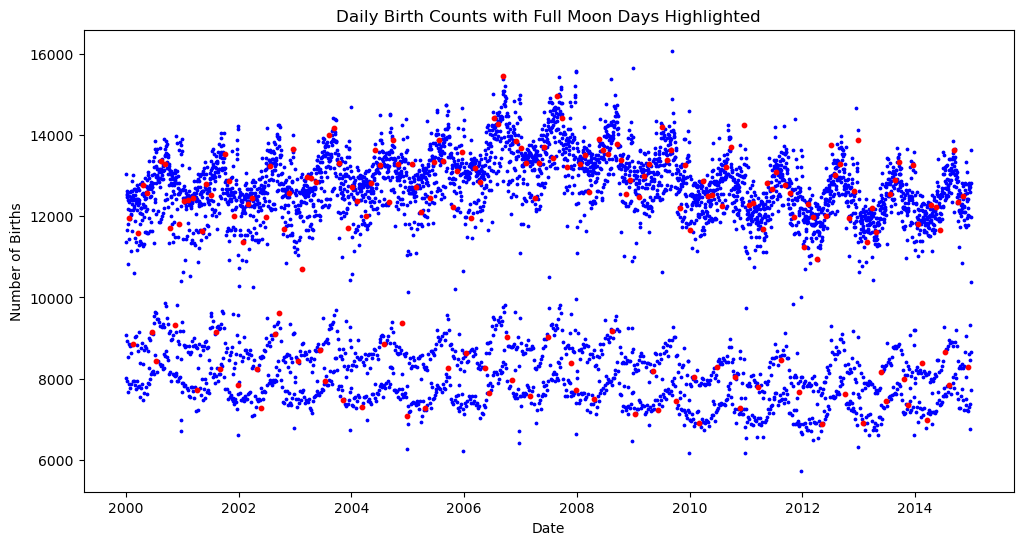

In [147]:
plt.figure(figsize=(12, 6))

# Plot birth counts per day as a line plot
plt.scatter(births['date_of_birth'], 
            births['birth_count'], 
            label='Daily Births', color='blue', s=3)

# Highlight the full moon days
plt.scatter(births[births['full_moon']]['date_of_birth'], 
            births[births['full_moon']]['birth_count'], 
            color='red', label='Full Moon days', zorder=5, s=10)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.title('Daily Birth Counts with Full Moon Days Highlighted')

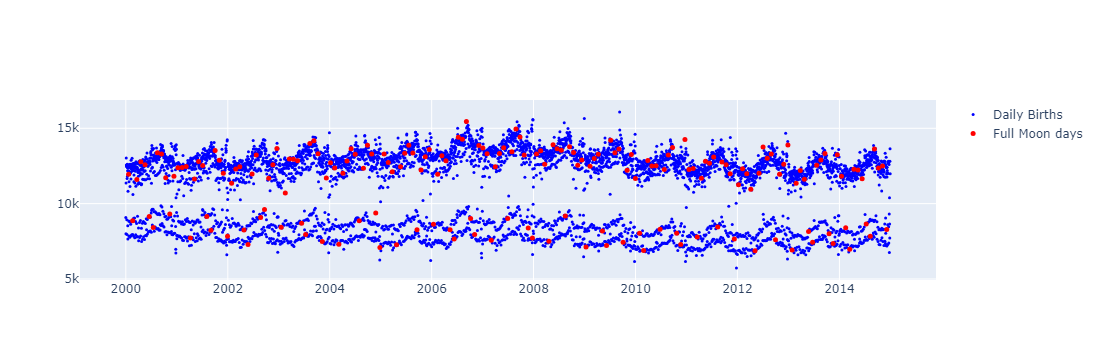

In [148]:
fig = go.Figure()

fig.add_scatter(
    x=births['date_of_birth'], 
    y=births['birth_count'], 
    mode='markers', 
    name='Daily Births', 
    marker=dict(color='blue', size=3)
)

# Add full moon markers
fig.add_scatter(x=births[births['full_moon']]['date_of_birth'], 
                y=births[births['full_moon']]['birth_count'], 
                mode='markers', name='Full Moon days', marker=dict(color='red', size=5))

# Show the plot
fig.show()

There's an odd split of data. Let's see if the lower group is made up of births over weekends

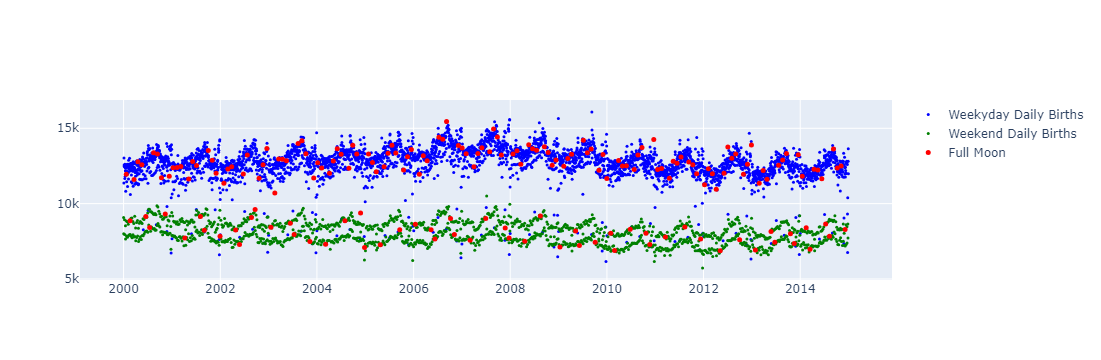

In [150]:
fig = go.Figure()

fig.add_scatter(
    x=births[births['day_of_week'].isin(range(1, 6))]['date_of_birth'], 
    y=births[births['day_of_week'].isin(range(1, 6))]['birth_count'], 
    mode='markers', 
    name='Weekyday Daily Births', 
    marker=dict(color='blue', size=3)
)

fig.add_scatter(
    x=births[births['day_of_week'].isin(range(6, 8))]['date_of_birth'], 
    y=births[births['day_of_week'].isin(range(6, 8))]['birth_count'], 
    mode='markers', 
    name='Weekend Daily Births', 
    marker=dict(color='green', size=3)
)

# Add full moon markers
fig.add_scatter(x=births[births['full_moon']]['date_of_birth'], 
                y=births[births['full_moon']]['birth_count'], 
                mode='markers', name='Full Moon', marker=dict(color='red', size=5))

# Show the plot
fig.show()

So there clearly is a drop in daily birthrates over the weekend. 

This is likely due to planned deliveries not happening during weekends where hospitals are likely less staffed. It would be interesting to see if that split reduces in countries that are less prone to give scheduled births.

Given this split, we need to separate weekday and weekend births to look into correlation between moon phases and births.

### Rolling averages

Let's look at rolling averages on the full data set vs full moon days only

In [203]:
weekday_averages = pd.DataFrame(births[births['day_of_week'].isin(range(1, 6))][['date_of_birth', 'day_of_week', 'birth_count', 'full_moon']])
weekend_averages = pd.DataFrame(births[births['day_of_week'].isin(range(6, 8))][['date_of_birth', 'day_of_week', 'birth_count', 'full_moon']])

weekday_averages['rolling_avg_all'] = weekday_averages['birth_count'].rolling(window=30).mean()
weekday_averages['rolling_avg_full_moon'] = weekday_averages['birth_count'].where(weekday_averages['full_moon']).rolling(window=30).mean()

weekend_averages['rolling_avg_all'] = weekend_averages['birth_count'].rolling(window=30).mean()
weekend_averages['rolling_avg_full_moon'] = weekend_averages['birth_count'].where(weekday_averages['full_moon']).rolling(window=30).mean()


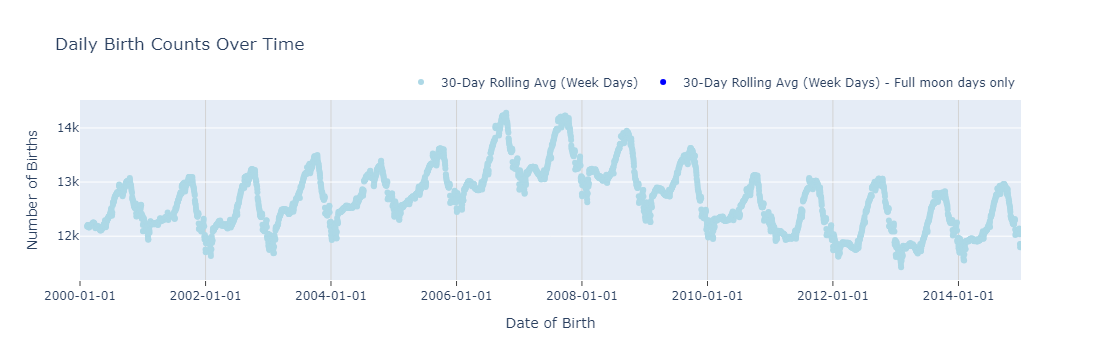

In [205]:
# Create the starting point of the range: January 1st of the first year
start_year = births['date_of_birth'].min().year
start_date = pd.Timestamp(f'{start_year}-01-01')

# Get the last date in the data for the end of the range
end_date = births['date_of_birth'].max()

fig = go.Figure()

# Plot 30-day rolling average for all weekdays
fig.add_trace(go.Scatter(
    x=weekday_averages['date_of_birth'], 
    y=weekday_averages['rolling_avg_all'], 
    mode='markers', name='30-Day Rolling Avg (Week Days)', marker=dict(color='#ADD8E6')
))

fig.add_trace(go.Scatter(
    x=weekday_averages[weekday_averages['full_moon']]['date_of_birth'], 
    y=weekday_averages[weekday_averages['full_moon']]['rolling_avg_full_moon'], 
    mode='markers', name='30-Day Rolling Avg (Week Days) - Full moon days only', marker=dict(color='#0000FF')
))


fig.update_layout(
    title='Daily Birth Counts Over Time',
    xaxis_title='Date of Birth',
    yaxis_title='Number of Births',

    # Customize the x-axis
    xaxis=dict(
        tickmode='auto',                # Automatically choose tick intervals
        showgrid=True,                  # Show grid lines for the x-axis
        gridwidth=1,                    # Set grid line width
        gridcolor='LightGray',          # Set grid line color
        tickformat='%Y-%m-%d',                # Display only the year in the format YYYY
        range=[start_date, end_date],   # Set chart range from Jan 1st of the first year to last date
        ticks='outside',                # Show ticks outside the axis
        tickangle=0 #-45                   # Rotate ticks slightly for better readability
    ),

    # Customize the legend to be horizontal and below the chart
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    
    # Increase bottom margin to create space for both the x-axis labels and legend
    # margin=dict(l=20, r=20, t=50, b=50)  # Adjust the bottom margin to avoid squeezing
)

# Show the plot
fig.show()


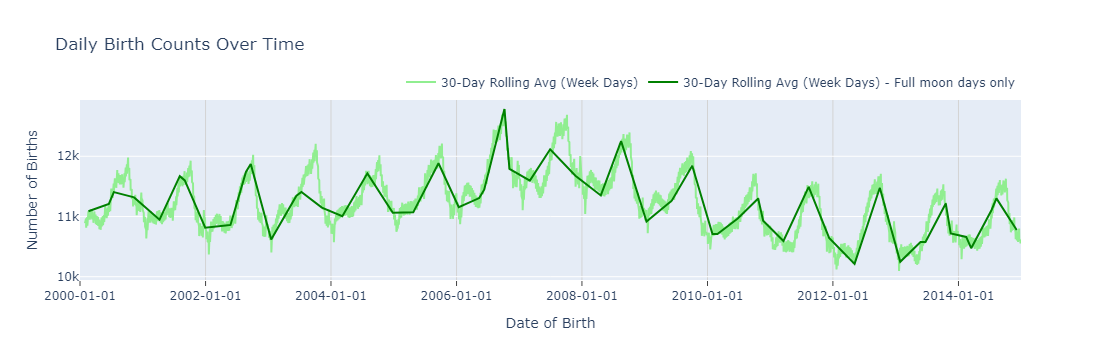

In [189]:
# Create the starting point of the range: January 1st of the first year
start_year = births['date_of_birth'].min().year
start_date = pd.Timestamp(f'{start_year}-01-01')

# Get the last date in the data for the end of the range
end_date = births['date_of_birth'].max()

fig = go.Figure()

# Plot 30-day rolling average for all weekdays
fig.add_trace(go.Scatter(
    x=averages[averages['day_of_week'].isin(range(6, 8))]['date_of_birth'], 
    y=averages[averages['day_of_week'].isin(range(6, 8))]['rolling_avg_all'], 
    mode='lines', name='30-Day Rolling Avg (Week Days)', line=dict(color='#90EE90')
))

fig.add_trace(go.Scatter(
    x=averages[(averages['day_of_week'].isin(range(6, 8))) & (averages['full_moon'])]['date_of_birth'], 
    y=averages[(averages['day_of_week'].isin(range(6, 8))) & (averages['full_moon'])]['rolling_avg_all'], 
    mode='lines', name='30-Day Rolling Avg (Week Days) - Full moon days only', line=dict(color='#008000')
))


fig.update_layout(
    title='Daily Birth Counts Over Time',
    xaxis_title='Date of Birth',
    yaxis_title='Number of Births',

    # Customize the x-axis
    xaxis=dict(
        tickmode='auto',                # Automatically choose tick intervals
        showgrid=True,                  # Show grid lines for the x-axis
        gridwidth=1,                    # Set grid line width
        gridcolor='LightGray',          # Set grid line color
        tickformat='%Y-%m-%d',                # Display only the year in the format YYYY
        range=[start_date, end_date],   # Set chart range from Jan 1st of the first year to last date
        ticks='outside',                # Show ticks outside the axis
        tickangle=0 #-45                   # Rotate ticks slightly for better readability
    ),

    # Customize the legend to be horizontal and below the chart
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    
    # Increase bottom margin to create space for both the x-axis labels and legend
    # margin=dict(l=20, r=20, t=50, b=50)  # Adjust the bottom margin to avoid squeezing
)

# Show the plot
fig.show()


In [204]:
set(weekend_averages['rolling_avg_full_moon'])

{nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan